#  Проект по прогнозированию количества заказов такси на следующий час

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить такую модель, чтобы метрика *RMSE* на тестовой выборке была не больше 48.

**Цель:** создать модель, прогнозирующую количество заказов такси на следующий час, с метрикой RMSE на тестовой выборке не более 48.

**Задачи:**

1. Проанализировать предоставленные данные;
2. Добавить входные признаки для обучения моделей;
3. Создать и обучить несколько моделей и подобрать гиперпараметры к ним;
4. Сделать прогноз на тестовой выборке с помощью наилучшей модели (метрика RMSE должна быть не более 48).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Установка-библиотек" data-toc-modified-id="Установка-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Установка библиотек</a></span></li><li><span><a href="#Загрузка-данных-и-первичный-анализ" data-toc-modified-id="Загрузка-данных-и-первичный-анализ-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных и первичный анализ</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка

### Установка библиотек

In [ ]:
!pip install scikit-learn --upgrade -q
!pip install matplotlib --upgrade -q
!pip install seaborn==0.13.0 -q
!pip install lightgbm --upgrade -q
!pip install catboost --upgrade -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [ ]:
from matplotlib.axes import Axes

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit
)
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from google.colab import drive
from google.colab import files

In [ ]:
# константа
RANDOM_STATE = 42

### Загрузка данных и первичный анализ

Загрузим данные, указав колонку с датами как индекс, переведя даты в нужный формат и упорядочив данные по возрастанию индекса.

In [ ]:
try:
    # для платформы Яндекс Практикум
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

except:
    # подключаем Google Drive
    drive.mount('/content/drive')

    # путь для Гугл Колаб
    taxi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Files/Portfolio/taxi.csv', index_col=[0], parse_dates=[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# сортировка по возрастанию индекса
taxi.sort_index(inplace=True)

Выведем информацию о датафрейме.

In [ ]:
# общая информация
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
# информация в числах
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
# первые 5 строк
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Пропусков нет, данные в корректном формате, среднее от медианы отличается не сильно, что означает отсуствие сильных выбросов или их небольшое количество.

Необходимо выполнить ресемплирование по одному часу, поскольку предсказывать число заказов нам надо будет на час вперед.

In [ ]:
# ресемплирование по одному часу
taxi = taxi.resample('1H').sum()

**Вывод:**

Данные загружены и подготовлены к дальнейшему анализу:
1. Отсуствуют пропуски и значительные выбросы;
2. Формат данных корректен;
3. Произведено ресемплирование по одному часу.

## Анализ

Построим гистограмму.

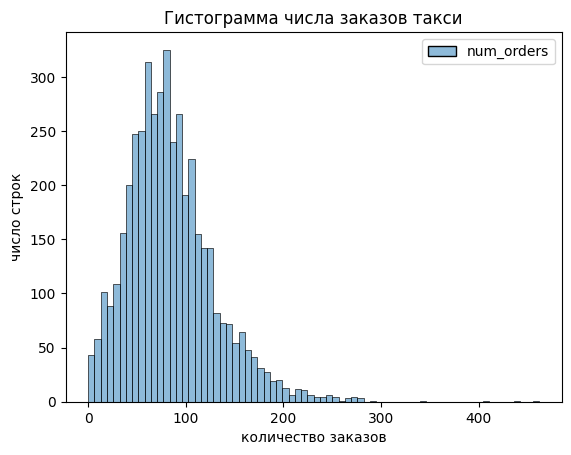

In [ ]:
# гитограмма числа заказов такси
hist = sns.histplot(taxi)
plt.title('Гистограмма числа заказов такси')
hist.set_ylabel('число строк')
hist.set_xlabel('количество заказов')
plt.show()

Распределение данных близко к логнормальному. Большое число заказов такси в час тоже встречается, но количество таких строк не велико.

Выведем период, за который у нас есть данные.

In [ ]:
print('Период:')
print('с:', taxi.index.min())
print('по:', taxi.index.max())

Период:
с: 2018-03-01 00:00:00
по: 2018-08-31 23:00:00


У нас есть данные за полгода (с марта 2018 по август 2018 включительно). Это значит, что мы сможем оценить только тренд, поскольку для оценки сезонности необходимы данные за несколько лет. С помощью seasonal_decompose разобьем данные на тренд, сезонность и остатки.

In [ ]:
# декомпозируем данные
decomposed = seasonal_decompose(taxi)

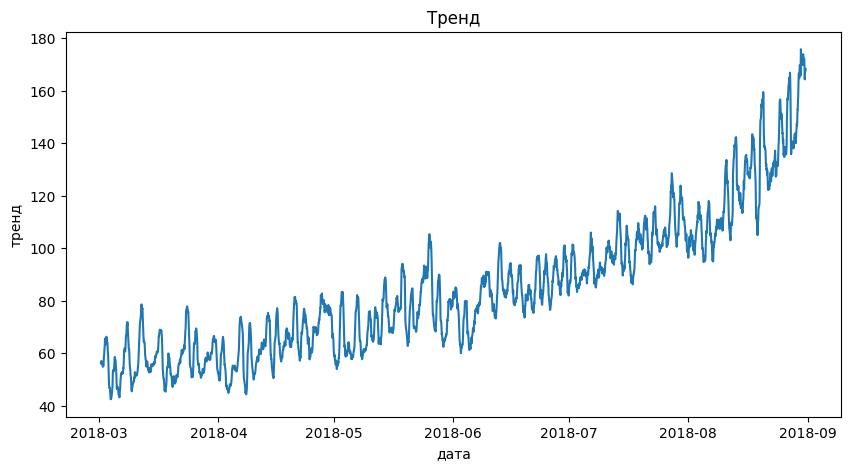

In [ ]:
# тренд
plt.figure(figsize=(10,5))
trend_plot = sns.lineplot(decomposed.trend)
plt.title('Тренд')
trend_plot.set_ylabel('тренд')
trend_plot.set_xlabel('дата')
plt.show()

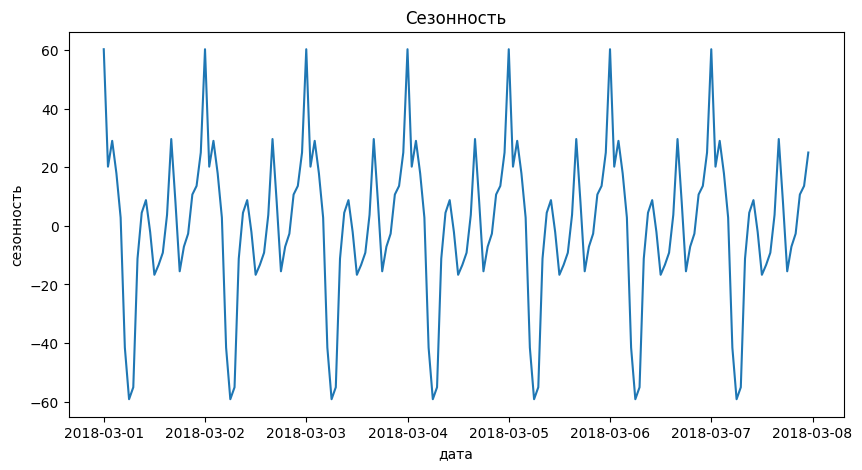

In [ ]:
# сезонность
plt.figure(figsize=(10,5))
seasonal_plot = sns.lineplot(decomposed.seasonal['2018-03-01':'2018-03-07'])
plt.title('Сезонность')
seasonal_plot.set_ylabel('сезонность')
seasonal_plot.set_xlabel('дата')
plt.show()

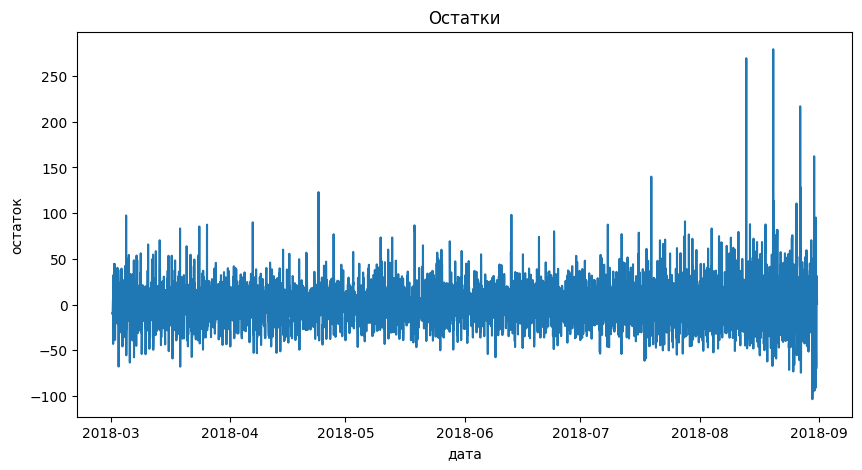

In [ ]:
# остатки
plt.figure(figsize=(10,5))
resid_plot = sns.lineplot(decomposed.resid)
plt.title('Остатки')
resid_plot.set_ylabel('остаток')
resid_plot.set_xlabel('дата')
plt.show()

Тренд явно показывает рост числа заказов такси к лету вплоть до августа. Возможно это связано увеличением числа клиентов в городе и их активностью (например, летом люди часто берут отпуск и улетают в другие города, используя такси как удобный вид транспорта до и из аэропорта).

Cезонность удалось определить только как колебания числа заказов в течение дня. Наименьшее число заказов наблюдается в 06:00, 12:00 и в 18:00, сразу после этого времени происходит резкий рост, пики числа заказов приходятся на 10:00, 16:00 и 00:00, затем резкий спад. Такую активность можно сопоставить с прилетающими и вылетающими рейсами и их популярностью среди пассажиров.

Проанализируем сезонность по дням. Для этого в начале ресемплируем по дням, декомпозируем с помощью seasonal_decompose и выведем график сезонности на экран.

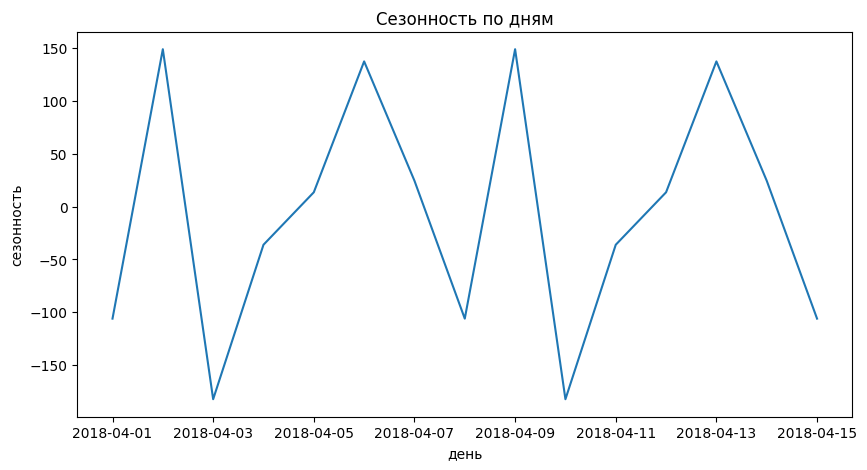

In [ ]:
# ресемплируем по дням
taxi_days = taxi.resample('1D').sum()

# декомпозируем данные
decomposed_days = seasonal_decompose(taxi_days)

# сезонность
plt.figure(figsize=(10,5))
seasonal_d_plot = sns.lineplot(decomposed_days.seasonal['2018-04-01':'2018-04-15'])
plt.title('Сезонность по дням')
seasonal_d_plot.set_ylabel('сезонность')
seasonal_d_plot.set_xlabel('день')
plt.show()

Видно наибольшее повышение числа заказов в понедельник и пятницу, наибольшее снижение - во вторник и воскресенье. Что может быть связано с командировочными активностями пассажиров: многие стремятся прилететь в город в понедельник и улететь в пятницу.

Создадим дополнительные колонки для анализа и последующего обучения моделей. Отдельно выделим месяц, день, день недели и час в качестве новых признаков, добавим скользяще среднее с возможностью регулирования окна (2 признака: скользящее среднее на несколько часов внутри одного дня и на день/несколько дней) и сдвиг значений числа заказов на регулируемое число строк (часов): каждый сдвиг на 1 час будет отдельным признаком.

In [ ]:
def make_features(data, max_lag, rm_size_hour, rm_size_day):
    # месяц
    data['month'] = data.index.month
    # день
    data['day'] = data.index.day
    # день недели
    data['dayofweek'] = data.index.dayofweek
    # час
    data['hour'] = data.index.hour
    # сдвиг
    for lag in range(1, max_lag + 1):

        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # скользящее среднее
    data['rolling_mean_h'] = data['num_orders'].shift(1)

    data['rolling_mean_h'] = data['rolling_mean_h'].rolling(rm_size_hour).mean()

    data['rolling_mean_d'] = data['num_orders'].shift(1)

    data['rolling_mean_d'] = data['rolling_mean_d'].rolling(rm_size_day).mean()

In [ ]:
# применим функцию к датафрейму
make_features(taxi, 14, 5, 24)

# выведем первые 25 строк
taxi.head(25)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,rolling_mean_h,rolling_mean_d
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.8,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.2,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,...,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.6,NaN
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,...,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,28.4,NaN


Посмотрим на различия медианного числа заказов в течение разных месяцев.

<ipython-input-20-0002b6c35370>:6: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  line_month_d = sns.lineplot(orders_by_month_d,\


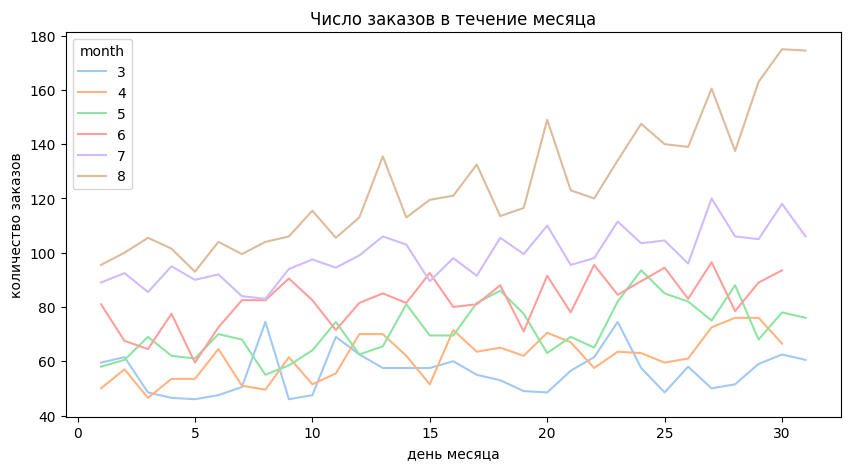

In [ ]:
# группируем по месяцам и дням
orders_by_month_d = taxi.groupby(['month', 'day']).agg('median').reset_index()

# график по месяцам
plt.figure(figsize=(10,5))
line_month_d = sns.lineplot(orders_by_month_d,\
             x=orders_by_month_d['day'],\
             y=orders_by_month_d['num_orders'],\
             hue=orders_by_month_d['month'],\
             palette = sns.color_palette('pastel'))
plt.title('Число заказов в течение месяца')
line_month_d.set_ylabel('количество заказов')
line_month_d.set_xlabel('день месяца')
plt.show()

<ipython-input-21-658911f40455>:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  line_month_d = sns.lineplot(selected_months,\


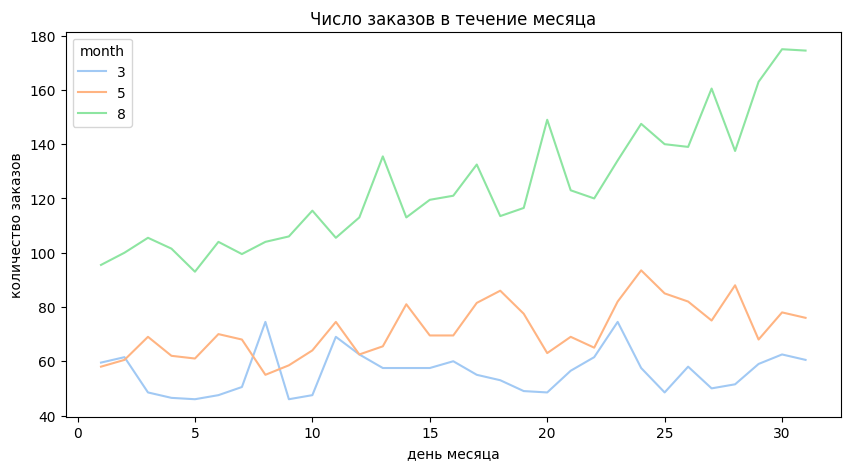

In [ ]:
# оставляем только март, май и август для сравнения
selected_months = orders_by_month_d.query('month == [3, 5, 8]')

# график по месяцам
plt.figure(figsize=(10,5))
line_month_d = sns.lineplot(selected_months,\
             x=selected_months['day'],\
             y=selected_months['num_orders'],\
             hue=selected_months['month'],\
             palette = sns.color_palette('pastel'))
plt.title('Число заказов в течение месяца')
line_month_d.set_ylabel('количество заказов')
line_month_d.set_xlabel('день месяца')
plt.show()

Август занимает лидирующие позиции (соответствует тренду). Также, если оставить на графике только август (месяц без национальных праздников), март (8 марта - Международный Женский День) и май (1 мая - День Весны и Труда, 9 мая - День Победы), то видны различия в колебании числа заказов. В августе это стандартные пики активности по понедельникам и пятницам, в марте - выражен пик 8 марта (четверг - праздничный день), в мае - привычные колебания заказов сменяются пиками на 3 число месяца (четверг, рабочий день), 6 (воскресенье, выходной), 11 (пятница, рабочий день) и провалами в дни праздников (1, 2, 9 мая). Такую особенность можно связать с тем, что многие люди в период майских праздников стремятся взять отпуск или отгул на работе, чтобы улететь на отдых, в сами праздничные дни активность возрастает в самом городе и пригороде, поездки в и из аэропорта минимальны. С 11 мая (пятница) привычная активность возобновляется. Таким образом, для анализа и прогноза может пригодиться производственный календарь, как дополнительный признак.

Посмотрим, есть ли различия в числе заказов в течение дня в зависимости от дня недели.

<ipython-input-22-c89ba5e0181e>:6: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  line_dow_h = sns.lineplot(orders_by_dow_h,\


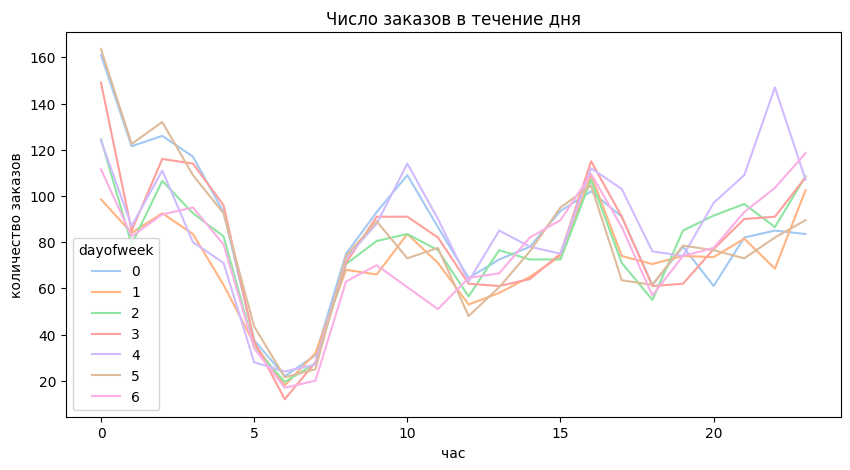

In [ ]:
# группируем по дням недели и часам
orders_by_dow_h = taxi.groupby(['dayofweek', 'hour']).agg('median').reset_index()

# график по дням недели
plt.figure(figsize=(10,5))
line_dow_h = sns.lineplot(orders_by_dow_h,\
             x=orders_by_dow_h['hour'],\
             y=orders_by_dow_h['num_orders'],\
             hue=orders_by_dow_h['dayofweek'],\
             palette = sns.color_palette('pastel'))
plt.title('Число заказов в течение дня')
line_dow_h.set_ylabel('количество заказов')
line_dow_h.set_xlabel('час')
plt.show()

Различия не велики. В пятницу наблюдается пик заказов в 22:00, в остальном графики более или менее похожи.

Изучим медианное количество заказов по дням недели.

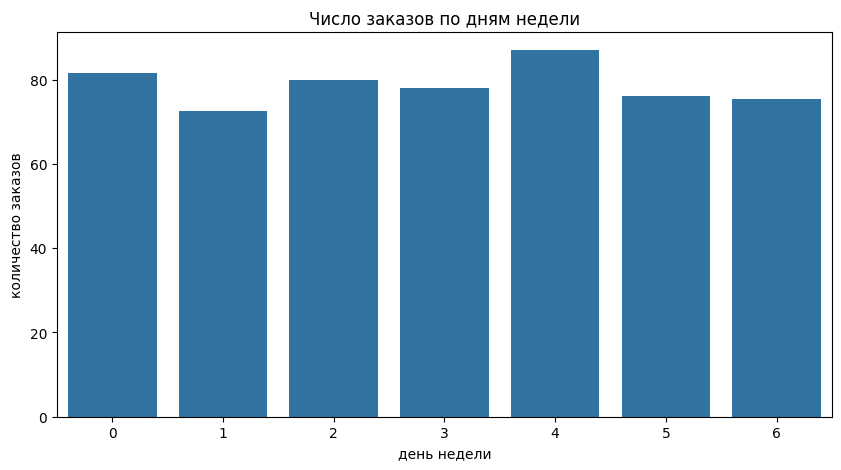

In [ ]:
# группируем по дням недели
orders_by_dow = taxi.groupby('dayofweek').agg('median').reset_index()

# график
plt.figure(figsize=(10,5))
barplot = sns.barplot(orders_by_dow,\
                      x=orders_by_dow['dayofweek'],\
                      y=orders_by_dow['num_orders'])
plt.title('Число заказов по дням недели')
barplot.set_ylabel('количество заказов')
barplot.set_xlabel('день недели')
plt.show()

Наибольшее число заказов приходится на пятницу (87) и понедельник (81,5), наименьшее - на вторник (72,5). Среди других дней недели различия не сильные.

Проверим временной ряд (колонку `num_orders`) на стационарность с помощью теста Дики-Фуллера.

In [ ]:
print('Нулевая гипотеза (H0): предполагает, что временной ряд имеет единичный корень, то есть он нестационарный.')
print('Альтернативная гипотеза (H1): предполагает, что временной ряд не имеет \
единичного корня, то есть он является стационарным.\n')

# проверяем временной ряд на стационарность тестом Дики-Фуллера
result = adfuller(taxi['num_orders'])
alpha = 0.05 # уровень статистической значимости
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
if result[1] < alpha:
    print('\nОтвергаем нулевую гипотезу.')
else:
    print('\nНе отвергаем нулевую гипотезу.')

Нулевая гипотеза (H0): предполагает, что временной ряд имеет единичный корень, то есть он нестационарный.
Альтернативная гипотеза (H1): предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным.

ADF Statistic: -3.0689242890279504
p-value: 0.028940051402613316
Critical Values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}

Отвергаем нулевую гипотезу.


Мы отвергли нулевую гипотезу, а значит, исследуемый ряд данных стационарен и мы можем его прогнозировать.

**Вывод:**

В данных прослеживается тренд увеличения числа заказов летом (наибольшее количество - в августе). Сезонность выражается в колебаниях числа заказов в течение дня (наименьшее число заказов наблюдается в 06:00, 12:00 и в 18:00, сразу после этого времени происходит резкий рост, пики числа заказов приходятся на 10:00, 16:00 и 00:00, затем резкий спад), что связано с повседневной активностью клиентов и популярностью и расписанием рейсов в аэропортах. Также, несмотря на небольшие различия в медианном количестве заказов по дням недели, выявлена сезонность: пик числа заказов в понедельник и пятницу, спад во вторник и воскресенье. В колебаниях по часам в зависимости от дня недели различия не большие. Колебания числа заказов в течение месяца связаны в основном в днем недели и национальными праздниками (в зависимости от праздника где-то наблюдается повышение активности, например, 8 марта, а где-то спад - майские праздники).

В данные добавлены признаки для дальнейшего обучения моделей: месяц, день, день недели и час, скользяще среднее (2 признака: скользящее среднее на несколько часов внутри одного дня и на день/несколько дней) и сдвиг значений числа заказов на регулируемое число строк (часов).

Выявлено, что исследуемый ряд данных стационарен, поэтому мы можем его прогнозировать.

## Обучение

Приступим к обучению моделей. Для начала удалим строки с пропусками, образовавшиеся из-за сдвигов.

In [ ]:
# удалим сроки с пропусками в датафрейме
taxi = taxi.dropna()

Выделим целевой и входящие признаки, разобъем данные на тренировочную и тестовую выборки (тестовая выборка по ТЗ равна 10%).

In [ ]:
# разделим целевой и входящие признаки
X = taxi.drop(['num_orders'], axis=1)
y = taxi['num_orders']

# разобъем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=0.1)

print('Размерность входных признаков тренировочной выборки', X_train.shape)
print('Размерность входных признаков обучающей выборки', X_test.shape)
print('Размерность целевого признака тренировочной выборки', y_train.shape)
print('Размерность целевого признака обучающей выборки', y_test.shape)

Размерность входных признаков тренировочной выборки (3952, 20)
Размерность входных признаков обучающей выборки (440, 20)
Размерность целевого признака тренировочной выборки (3952,)
Размерность целевого признака обучающей выборки (440,)


Данные разделились корректно. Создадим пайплайны с моделями и предобработкой числовых данных (с помощью StandardScaler). Модели будем использовать следующие: DecisionTreeRegressor, LGBMRegressor, CatBoostRegressor и LinearRegression.

In [ ]:
# пайплайн с DecisionTreeRegressor
pipe_tree = Pipeline(
    [
        ('preprocessor', StandardScaler()),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

# пайплайн с LGBMRegressor
pipe_lgbm = Pipeline(
    [
        ('preprocessor', StandardScaler()),
        ('models', LGBMRegressor(random_state=RANDOM_STATE))
    ]
)

# пайплайн с CatBoostRegressor
pipe_catboost = Pipeline(
    [
        ('preprocessor', StandardScaler()),
        ('models', CatBoostRegressor(random_seed=RANDOM_STATE))
    ]
)

# пайплайн с LinearRegression
pipe_linear = Pipeline(
    [
        ('preprocessor', StandardScaler()),
        ('models', LinearRegression())
    ]
)

Гиперпараметры будем подбирать с помощью RandomizedSearchCV. Создадим словари с гиперпараметрами для каждой модели кроме LinearRegression.

In [ ]:
# словарь с параметрами для модели DecisionTreeRegressor
param_tree = [

    {
        'models__max_depth': range(3,20),
        'models__max_features': range(3,20),
        'models__min_samples_split': range(2,8)
    }

]

# словарь с параметрами для модели LGBMRegressor
param_lgbm = [

    {
        'models__max_depth': range(1,5),
        'models__n_estimators': [50, 100, 150, 200]
    }

]

# словарь с параметрами для модели CatBoostRegressor
param_catboost = [

    {
        'models__depth': range(1,5),
        'models__iterations': [50, 100, 150, 200]
    }

]

Метрика по ТЗ - RMSE, создадим ее с помощью make_scorer.

In [ ]:
def get_rmse(y_true, y_pred):
    # вычисляем RMSE
    metric = mean_squared_error(y_true, y_pred, squared=False)
    return metric

# создаём пользовательскую метрику
scorer = make_scorer(get_rmse, greater_is_better = False)

Создадим функцию с подбором гиперпараметров и выводом метрики и лучшей модели.

In [ ]:
# функция для подбора гиперпараметров и оценки времени обучения и предсказания модели
def rs_model(pipe_model, params):

    # задаем кросс-валидацию TimeSeriesSplit
    ts_cv = TimeSeriesSplit(n_splits = 3)

    # осуществляем подбор гиперпараметров с помощью RandomizedSearchCV
    rs = RandomizedSearchCV(
    pipe_model,
    params,
    cv=ts_cv,
    scoring=scorer,
    n_iter=10,
    random_state=RANDOM_STATE,
    n_jobs=-1)

    rs.fit(X_train, y_train)

    print('Метрика для лучшей модели на кросс-валидации:\n', rs.best_score_)
    print('\nЛучшая модель и её параметры:\n\n', rs.best_estimator_)

    return rs.best_estimator_

Подберем гиперпараметры поочереди для каждой модели и посмотрим на метрики.

In [ ]:
# применяем функцию к пайплайну с DecisionTreeRegressor
best_tree = rs_model(pipe_tree, param_tree)

Метрика для лучшей модели на кросс-валидации:
 -33.44012794304097

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor', StandardScaler()),
                ('models',
                 DecisionTreeRegressor(max_depth=4, max_features=6,
                                       min_samples_split=3, random_state=42))])


In [ ]:
# применяем функцию к пайплайну с LGBMRegressor
best_lgbm = rs_model(pipe_lgbm, param_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3242
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 20
[LightGBM] [Info] Start training from score 78.451417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [ ]:
# применяем функцию к пайплайну с CatBoostRegressor
best_catboost = rs_model(pipe_catboost, param_catboost)

Learning rate set to 0.188252
0:	learn: 35.8397469	total: 50.9ms	remaining: 10.1s
1:	learn: 33.5097591	total: 54.3ms	remaining: 5.38s
2:	learn: 31.7290085	total: 57.4ms	remaining: 3.77s
3:	learn: 30.1165799	total: 59.8ms	remaining: 2.93s
4:	learn: 29.1445566	total: 64.4ms	remaining: 2.51s
5:	learn: 28.1731520	total: 67.2ms	remaining: 2.17s
6:	learn: 27.6653095	total: 70.2ms	remaining: 1.93s
7:	learn: 27.1330064	total: 72.7ms	remaining: 1.74s
8:	learn: 26.3590041	total: 75ms	remaining: 1.59s
9:	learn: 25.8661530	total: 77.5ms	remaining: 1.47s
10:	learn: 25.5425095	total: 80.4ms	remaining: 1.38s
11:	learn: 25.2880274	total: 83.3ms	remaining: 1.3s
12:	learn: 24.9099002	total: 92ms	remaining: 1.32s
13:	learn: 24.7197989	total: 96.5ms	remaining: 1.28s
14:	learn: 24.5477357	total: 99.6ms	remaining: 1.23s
15:	learn: 24.2961423	total: 103ms	remaining: 1.18s
16:	learn: 24.1564152	total: 106ms	remaining: 1.14s
17:	learn: 24.0783857	total: 109ms	remaining: 1.1s
18:	learn: 24.0309166	total: 112ms	

In [ ]:
pipe_linear.fit(X_train, y_train)

pred_linear = pipe_linear.predict(X_train)

print('Метрика на тренировочной выборке:', get_rmse(y_train, pred_linear))

Метрика на тренировочной выборке: 29.636454524881596


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Вывод:**

Наилучшие модели по метрике RMSE: LGBMRegressor и CatBoostRegressor. Исходя из метрики на тренировочной выборке выбираем модель CatBoostRegressor (ее результат 26.7 против 26.8 у LGBMRegressor).

## Тестирование

Предскажем число заказов на тестовых данных с помощью CatBoostRegressor.

In [ ]:
# спрогнозируем число заказов на тестовой выборке с помощью CatBoostRegressor
y_test_pred_catboost = best_catboost.predict(X_test)
print('Метрика на тестовой выборке:', get_rmse(y_test, y_test_pred_catboost))

Метрика на тестовой выборке: 43.11569215727467


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Метрика на тестовых данных получились почти в 1,5 раза выше, чем на тренировочных данных, но все еще не превышает порога, установленного заказчиком (RMSE не более 48). Проанализируем остатки.

In [ ]:
# создадим функцию, которая будет строить следующие графики
def residuals_charts(y_test, predictions):
    residuals = y_test - predictions

    # гистограмма остатков
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals, bins=30)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Предсказания модели')

    # диаграмма рассеяния остатков
    axes[1].scatter(x=predictions, y=residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Дисперсия остатков')
    plt.show()

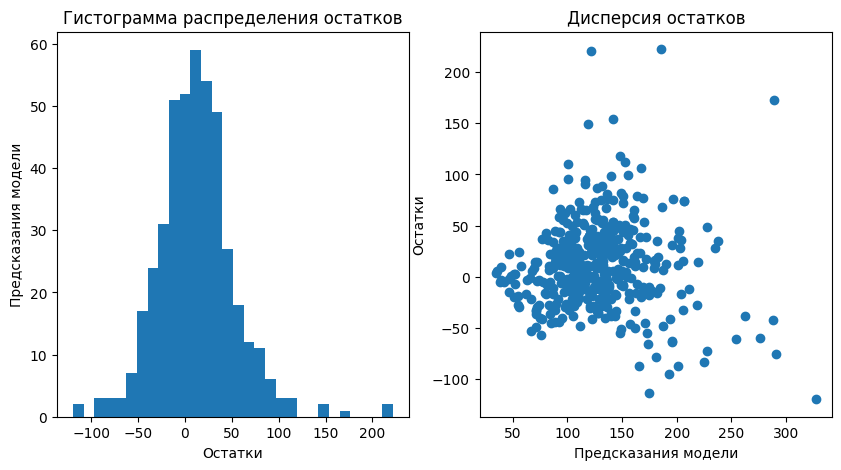

In [ ]:
# применим функцию к предсказаниям CatBoostRegressor
residuals_charts(y_test, y_test_pred_catboost)

**Вывод:**

Остатки равномерно распределены относительно 0. Дисперсия остатков равномерна на небольших предсказаниях (число заказов до 125 +-60), далее периодически встречаются значительные ошибки как в большую, так и в меньшую стороны (на 60 заказов и больше). Для улучшения модели можно рекомендовать добавить признак с данными из производственного календаря.

## Общий вывод

Проведен первичный анализ данных и ресемплирование числа заказов по одному часу.


В ходе исследовательского анализа данных выявлено следующее:

1. Тренд увеличения числа заказов летом (наибольшее количество - в августе).
2. Колебания числа заказов в течение дня (наименьшее число заказов наблюдается в 06:00, 12:00 и в 18:00, сразу после этого времени происходит резкий рост, пики числа заказов приходятся на 10:00, 16:00 и 00:00, затем резкий спад), что связано с повседневной активностью клиентов и популярностью и расписанием рейсов в аэропортах.
3. В пятницу и понедельник наблюдается увеличение числа заказов, во вторник и воскресенье - спад.
4. Колебания числа заказов в течение месяца связаны в основном в днем недели и национальными праздниками (в зависимости от праздника где-то наблюдается повышение активности, например, 8 марта, а где-то спад - майские праздники).

Проведен тест Дики-Фуллера, доказана стационарность исследуемого ряда данных.

В данные добавлены признаки: месяц, день, день недели и час, скользящее среднее и сдвиг значений числа заказов.


С помощью RandomizedSearchCV обучены следующие модели и подобраны гиперпараметры к ним: LinearRegression, DecisionTreeRegressor, CatBoostRegressor и LGBMRegressor.

Наилучшая модель по метрике RMSE на тренировочной выборке: CatBoostRegressor (26.7). Метрика на тестовой выборке 43.1

После анализа остатков выявлено, что они распределены равномерно относительно нуля. Дисперсия остатков равномерна при прогнозе небольшого количества заказов/час (до 125 +-60), прогнозы большого количества заказов/час даются модели хуже, ошибка уже более 60. Для улучшения модели рекомендуется добавить признак с данными из производственного календаря.